In [1]:
# --- Cell 1: Install (if needed) & imports, constants, seeds ---

# If you need these in a fresh runtime, uncomment:
# !pip install -q tensorflow matplotlib pandas huggingface_hub

import os, random, math, itertools
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd

np.random.seed(42)
tf.random.set_seed(42)

# Image size chosen to be OCR-friendly and fast
IMG_HEIGHT, IMG_WIDTH = 32, 128   # (H, W)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# --- Cell 2: Download dataset repo with huggingface_hub & unzip ---

from huggingface_hub import snapshot_download
import zipfile

dataset_dir = snapshot_download(
    repo_id="YCAI3/HCI_P2",
    repo_type="dataset",
    local_dir="./HCI_Dataset",
    ignore_patterns=[".gitattributes"]
)

print("Dataset downloaded to:", dataset_dir)

zip_path = os.path.join(dataset_dir, "HCI_Dataset.zip")
extract_dir = os.path.join(dataset_dir, "unzipped")

# Extract the dataset if not already extracted
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)

print("✅ Extracted to:", extract_dir)
print("Top-level in 'unzipped':", os.listdir(extract_dir))

# Base path where the actual images live
base_path = "./HCI_Dataset/unzipped/HCI_Dataset"
assert os.path.exists(base_path), f"Expected folder not found: {base_path}"


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/971 [00:00<?, ?B/s]

HCI_Dataset.zip:   0%|          | 0.00/1.29G [00:00<?, ?B/s]

Dataset downloaded to: /content/HCI_Dataset
✅ Extracted to: /content/HCI_Dataset/unzipped
Top-level in 'unzipped': ['__MACOSX', 'HCI_Dataset']


In [3]:
# --- Cell 3: Gather image paths and word labels from filenames ---

# Recursively collect *.jpg
image_paths = glob(os.path.join(base_path, "**", "*.jpg"), recursive=True)
print("Total images found:", len(image_paths))

def get_word_label_from_filename(path):
    """
    Filenames look like:  100_Classmates_13942.jpg
    We want the 'Classmates' portion (case-sensitive).
    """
    fname = os.path.basename(path)
    parts = fname.split("_")
    return parts[1] if len(parts) >= 2 else ""

data = pd.DataFrame({
    "path": image_paths,
    "label": [get_word_label_from_filename(p) for p in image_paths]
})

# Basic sanity check
print(data.sample(5))
print("Unique sample words:", data['label'].nunique())


Total images found: 609656
                                                     path          label
497818  ./HCI_Dataset/unzipped/HCI_Dataset/184/6/369_g...   gatecrashing
180397  ./HCI_Dataset/unzipped/HCI_Dataset/23/3/418_re...     reasserted
232696  ./HCI_Dataset/unzipped/HCI_Dataset/148/3/354_R...           RUHR
19774   ./HCI_Dataset/unzipped/HCI_Dataset/131/6/344_f...         fluxed
244604  ./HCI_Dataset/unzipped/HCI_Dataset/12/1/242_CI...  CIVILIZATIONS
Unique sample words: 237485


In [5]:
# --- Cell 4 (fixed): Build character vocabulary and lookup layers ---

# Build charset from all labels (case-sensitive; includes digits + letters)
all_text = "".join(data["label"].astype(str).tolist())
unique_chars = sorted(list(set(all_text)))
print("Unique chars ({}):".format(len(unique_chars)), unique_chars[:80], "...")

# No OOV, no mask; both layers must match
char_to_num = layers.StringLookup(
    vocabulary=unique_chars,
    num_oov_indices=0,
    mask_token=None
)

num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    invert=True,
    num_oov_indices=0,
    mask_token=None
)

# Quick encode/decode test
test_word = data["label"].iloc[0]
enc = char_to_num(tf.strings.unicode_split(test_word, "UTF-8"))
dec = tf.strings.reduce_join(num_to_char(enc)).numpy().decode("utf-8")
print("Test label:", test_word, "| Encoded len:", enc.shape[0], "| Decoded:", dec)


Unique chars (62): ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] ...
Test label: Deescalate | Encoded len: 10 | Decoded: Deescalate


In [6]:
# --- Cell 5: Preprocessing functions (image, label) ---

def preprocess_example(path, label_str):
    # Image: grayscale, resize to (H, W), normalize 0..1
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img_bytes, channels=1)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.cast(img, tf.float32) / 255.0

    # Label: string -> list of characters -> int ids
    label_chars = tf.strings.unicode_split(label_str, "UTF-8")
    label_ids = char_to_num(label_chars)  # int32 tensor of shape [seq_len]

    return img, label_ids


In [7]:
# --- Cell 6: Split datasets and map preprocess (no batching yet) ---

# Shuffle deterministically, then split 80/10/10
idx = np.arange(len(data))
np.random.shuffle(idx)

train_end = int(0.8 * len(idx))
val_end   = int(0.9 * len(idx))

train_idx = idx[:train_end]
val_idx   = idx[train_end:val_end]
test_idx  = idx[val_end:]

train_paths = data["path"].values[train_idx]
train_labels= data["label"].values[train_idx]
val_paths   = data["path"].values[val_idx]
val_labels  = data["label"].values[val_idx]
test_paths  = data["path"].values[test_idx]
test_labels = data["label"].values[test_idx]

print("Splits -> train:", len(train_paths), "val:", len(val_paths), "test:", len(test_paths))

# TF datasets (path, label_string) -> map to (image, label_ids)
train_raw = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_raw   = tf.data.Dataset.from_tensor_slices((val_paths,   val_labels))
test_raw  = tf.data.Dataset.from_tensor_slices((test_paths,  test_labels))

train_mapped = train_raw.map(preprocess_example, num_parallel_calls=AUTOTUNE)
val_mapped   = val_raw.map(preprocess_example,   num_parallel_calls=AUTOTUNE)
test_mapped  = test_raw.map(preprocess_example,  num_parallel_calls=AUTOTUNE)


Splits -> train: 487724 val: 60966 test: 60966


In [13]:
# --- Cell 7: Batch & pad datasets ---

# Map to ensure precise dtypes for padding later
def _to_dtypes(img, label_ids):
    # img already float32 in [0,1]; label_ids currently int32 from StringLookup
    img = tf.cast(img, tf.float32)
    label_ids = tf.cast(label_ids, tf.int32)
    return img, label_ids

train_mapped = train_mapped.map(_to_dtypes, num_parallel_calls=AUTOTUNE)
val_mapped   = val_mapped.map(_to_dtypes,   num_parallel_calls=AUTOTUNE)
test_mapped  = test_mapped.map(_to_dtypes,  num_parallel_calls=AUTOTUNE)

# Padding values must match dtypes exactly:
PADDING_VALUES = (
    tf.constant(0.0, dtype=tf.float32),  # image pad
    tf.constant(-1,  dtype=tf.int32)     # label pad with -1
)

train_ds = (train_mapped
            .shuffle(8192, reshuffle_each_iteration=True)
            .padded_batch(
                BATCH_SIZE,
                padded_shapes=([IMG_HEIGHT, IMG_WIDTH, 1], [None]),
                padding_values=PADDING_VALUES
            )
            .prefetch(AUTOTUNE))

val_ds = (val_mapped
          .padded_batch(
              BATCH_SIZE,
              padded_shapes=([IMG_HEIGHT, IMG_WIDTH, 1], [None]),
              padding_values=PADDING_VALUES
          )
          .prefetch(AUTOTUNE))

test_ds = (test_mapped
           .padded_batch(
               BATCH_SIZE,
               padded_shapes=([IMG_HEIGHT, IMG_WIDTH, 1], [None]),
               padding_values=PADDING_VALUES
           )
           .prefetch(AUTOTUNE))

# Quick sanity check (one batch)
for imgs, labs in train_ds.take(1):
    print("Batch images:", imgs.shape, imgs.dtype)
    print("Batch labels shape:", labs.shape, labs.dtype)
    print("First label (padded ids):", labs[0][:20].numpy())
    break


Batch images: (32, 64, 256, 1) <dtype: 'float32'>
Batch labels shape: (32, 17) <dtype: 'int32'>
First label (padded ids): [58 44 55 43 43 50 47 39 54 -1 -1 -1 -1 -1 -1 -1 -1]


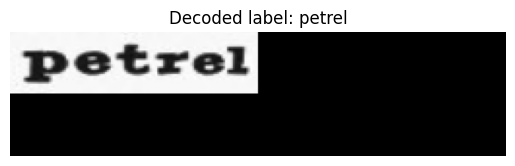

In [15]:
# --- Cell 8: Visualize & decode one example from a batch ---

def decode_label_ids(label_ids_tensor):
    # Remove padding (-1), then map ids -> chars, join
    valid = tf.boolean_mask(label_ids_tensor, label_ids_tensor != -1)
    chars = num_to_char(valid)  # vector of strings
    return tf.strings.reduce_join(chars).numpy().decode("utf-8")

import matplotlib.pyplot as plt

for imgs, labs in train_ds.take(1):
    idx = 0
    plt.imshow(tf.squeeze(imgs[idx]), cmap='gray')
    plt.title("Decoded label: " + decode_label_ids(labs[idx]))
    plt.axis('off')
    plt.show()
    break


In [25]:
# Robust CTC loss that handles -1 padding and (B,1) length tensors
def ctc_loss_func(y_true, y_pred):
    """
    y_true: (B, L) int32 with -1 padding
    y_pred: (B, T, C) float (probabilities or logits); T = time steps
    """
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.float32)

    # lengths
    B = tf.shape(y_true)[0]
    T = tf.shape(y_pred)[1]                        # time steps from the network
    label_len = tf.reduce_sum(tf.cast(y_true != -1, tf.int32), axis=1)  # (B,)

    # Clip label lengths so they never exceed T (prevents CTC length errors)
    label_len = tf.minimum(label_len, T)

    # Replace -1 padding with 0 (won't be read past label_len)
    y_true_fixed = tf.where(y_true < 0, tf.zeros_like(y_true), y_true)

    # ctc_batch_cost expects shape (B, 1) for lengths
    input_len = tf.fill([B, 1], T)
    label_len = tf.reshape(label_len, [B, 1])

    return tf.keras.backend.ctc_batch_cost(y_true_fixed, y_pred, input_len, label_len)


In [26]:
# --- Cell 10: Build CRNN (CNN -> BiLSTM) ---

from tensorflow.keras import layers, models

def build_crnn_lstm(img_h=IMG_HEIGHT, img_w=IMG_WIDTH, vocab_size=None):
    assert vocab_size is not None, "Pass vocab_size=len(unique_chars)+1 (for CTC blank)."

    inp = layers.Input(shape=(img_h, img_w, 1), name="image")  # (H, W, 1)

    # --- CNN feature extractor (≥3 conv layers as required) ---
    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(inp)
    x = layers.MaxPooling2D((2,2))(x)  # -> (H/2, W/2)

    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)  # -> (H/4, W/4)

    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)  # -> (H/8, W/8)

    # We know these sizes statically from the constants + pooling:
    Hp = img_h // 8        # time features height-collapsed dimension
    Wp = img_w // 8        # time steps along width
    C  = 128               # last conv channels

    # Make width the "time" axis and flatten (H', C) into features
    x = layers.Permute((2, 1, 3))(x)           # (batch, W', H', C)
    x = layers.Reshape((Wp, Hp * C))(x)        # (batch, T=Wp, features=Hp*C)

    # --- BiLSTM stack ---
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64,  return_sequences=True))(x)

    # --- Classification (num classes + 1 blank) ---
    out = layers.Dense(vocab_size, activation="softmax")(x)  # (B, T, C)

    return models.Model(inputs=inp, outputs=out, name="CRNN_LSTM")

# vocab size = unique chars + 1 for CTC blank
VOCAB_SIZE = len(unique_chars) + 1
crnn_lstm = build_crnn_lstm(vocab_size=VOCAB_SIZE)

crnn_lstm.summary()


Model: "CRNN_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 256, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 256, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_2 (Permute)             │ (None, 32, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 32, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 32, 256)        │     1,180,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 32, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32, 63)         │         8,127 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,575,231 (6.01 MB)

 Trainable params: 1,575,231 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Peek at one batch
imgs, labs = next(iter(train_ds))
print("Batch images:", imgs.shape, imgs.dtype)
print("Batch labels:", labs.shape, labs.dtype)

# Check model output time steps T
probe = crnn_lstm(imgs[:1])        # forward pass a single image
print("Model output shape (B, T, C):", probe.shape)


Batch images: (32, 64, 256, 1) <dtype: 'float32'>
Batch labels: (32, 14) <dtype: 'int32'>
Model output shape (B, T, C): (1, 32, 63)


In [30]:
import math
from tensorflow import keras
import tensorflow as tf

# --- Make small, clean subsets (500 train, 100 val) ---
SUB_TRAIN = 500
SUB_VAL   = 100

subset_train = (
    train_ds
    .unbatch()                 # go back to single examples
    .take(SUB_TRAIN)           # keep only 500
    .batch(BATCH_SIZE)         # re-batch
    .prefetch(tf.data.AUTOTUNE)
)

subset_val = (
    val_ds
    .unbatch()
    .take(SUB_VAL)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

steps_per_epoch  = math.ceil(SUB_TRAIN / BATCH_SIZE)
validation_steps = math.ceil(SUB_VAL   / BATCH_SIZE)

# --- Recompile (use your working CTC loss) ---
crnn_lstm.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=ctc_loss_func
)

# --- Quick smoke test training run ---
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
]

history_lstm_adam = crnn_lstm.fit(
    subset_train,
    validation_data=subset_val,
    epochs=10,                      # just to confirm it fully runs
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - loss: 31.5159 - val_loss: 32.1803
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0000e+00 - val_loss: 32.1803
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 31.0658 - val_loss: 32.0779
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0000e+00 - val_loss: 32.0779
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 31.2898 - val_loss: 31.9672
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0000e+00 - val_loss: 31.9672
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 31.2636 - val_loss: 31.9176
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0000e+00 - val_loss: 31.9176
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 30.7797 - val_loss: 31.8593
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0000e+00 - val_loss: 31.8593


In [31]:
# Peek at a few labels from the subset to make sure they aren't empty
for imgs, labs in subset_train.take(1):
    lens = tf.cast(tf.reduce_sum(tf.cast(labs != -1, tf.int32), axis=1), tf.int32)  # count non -1 tokens
    print("Label lengths:", lens.numpy()[:32])
    # Optional: decode the first few to human-readable
    for i in range(min(5, labs.shape[0])):
        valid = tf.boolean_mask(labs[i], labs[i] != -1)
        print(i, tf.strings.reduce_join(num_to_char(valid)).numpy().decode("utf-8"))


Label lengths: [ 8 13  8  8  7 13  8 14  8  5  8  6  8  6  4  5  6  7 11  6  8  6  8  7
  7  8  9 12  8 10 11  9]
0 TANZANIA
1 Geriatricians
2 Heretics
3 Arranges
4 Nodules
